## 1. Imports and Setup

Initializes libraries, model classes, and tools. Sets plotting style and ensures the model directory exists.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import glob
import re
import warnings

# Models
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Tools
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline

# Setup
sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

if not os.path.exists("../../models"):
    os.makedirs("../../models")

## 2. Load & Preprocess Data

Loads the cleaned dataset

In [11]:
# FIND FILE AUTOMATICALLY
file_path = "../../Datasets/Cleaned_Datasets/Advertising/advertising_v2_tod_only.csv"

if os.path.exists(file_path):
    print(f"Loading file: {file_path}")
    df = pd.read_csv(file_path)
    print(f"Final Data Shape: {df.shape}")
else:
    raise FileNotFoundError(f"❌ File not found: {file_path}")

Loading file: ../../Datasets/Cleaned_Datasets/Advertising/advertising_v2_tod_only.csv
Final Data Shape: (1000, 31)


## 3. Feature Engineering & Selection

Defines the target variable, removes potential data leakage, sanitizes column names for compatibility, splits the data, and selects the top 10 most relevant features.

Dropped Leakage: ['conversion_rate', 'view_time', 'click_through_rate', 'cost_per_click', 'ROI', 'Unnamed: 0']

🔍 Training Inspector Models to compare Feature Importance...
   -> Analyzing with RandomForest...
   -> Analyzing with XGBoost...
   -> Analyzing with LightGBM...


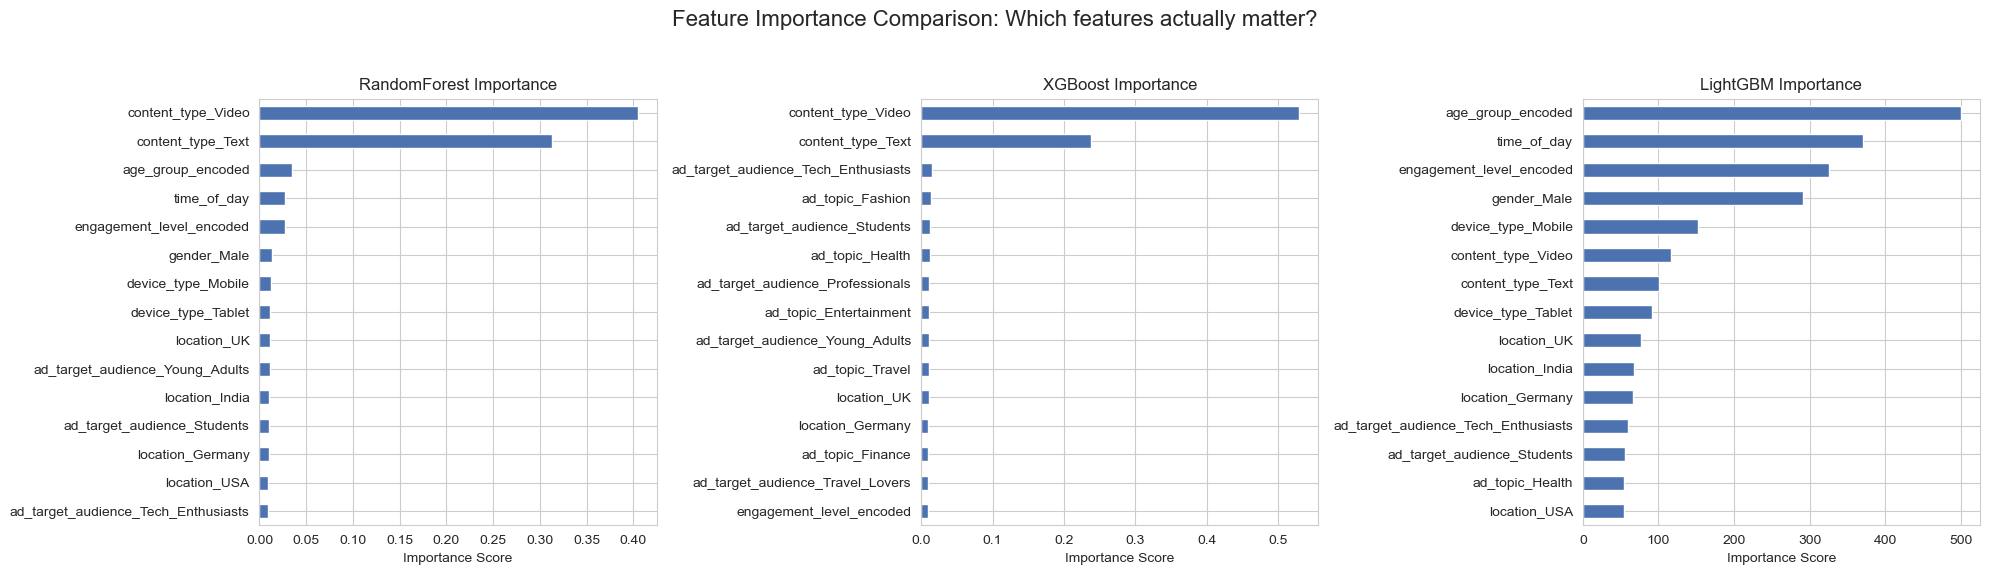

In [12]:
# DEFINE TARGET & LEAKAGE
TARGET = 'conversion_rate'

leakage_cols = [
    TARGET, 
    'view_time',
    'click_through_rate',
    'cost_per_click',
    'ROI',
    'Unnamed: 0', 'Unnamed__0'
]

cols_to_drop = [c for c in leakage_cols if c in df.columns]
X = df.drop(columns=cols_to_drop)
y = df[TARGET]

print(f"Dropped Leakage: {cols_to_drop}")

# SPLIT DATA (Train/Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\n🔍 Training Inspector Models to compare Feature Importance...")

# Define Inspectors
inspectors = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, objective='reg:squarederror', random_state=42),
    'LightGBM': LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)
}

# Setup Plotting 
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Feature Importance Comparison: Which features actually matter?', fontsize=16)

# Loop, Train, and Plot
for i, (name, model) in enumerate(inspectors.items()):
    print(f"   -> Analyzing with {name}...")
    
    # Train on FULL X_train
    model.fit(X_train, y_train)
    
    # Extract Importance
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feat_series = pd.Series(importances, index=X_train.columns)
        
        # Plot Top 15
        ax = axes[i]
        feat_series.nlargest(15).plot(kind='barh', ax=ax, color='#4c72b0')
        
        ax.set_title(f"{name} Importance")
        ax.invert_yaxis()
        ax.set_xlabel("Importance Score")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 4. Baseline Model Evaluation

Trains standard models (RandomForest, XGBoost, LightGBM) without optimization to establish a performance baseline. Calculates key metrics R2, RMSE, and Cross-Validation scores to assess initial accuracy.

In [13]:
# Define Baseline Models
models = {
    'RandomForest': RandomForestRegressor(random_state=42), 
    'XGBoost': XGBRegressor(random_state=42, objective='reg:squarederror'),
    'LightGBM': LGBMRegressor(random_state=42, verbose=-1)
}

print("\n📊 USER ENGINE BASELINE RESULTS")
print("-" * 105)
print(f"{'Model':<15} | {'Test R2':<10} | {'Train R2':<10} | {'Gap':<10} | {'RMSE':<10} | {'CV Score':<10}")
print("-" * 105)

for name, model in models.items():
    # Create Pipeline
    pipeline = Pipeline([
        ('selector', SelectKBest(score_func=f_regression, k=10)),
        ('regressor', model)
    ])
    
    # Train Pipeline on Full Train Set
    pipeline.fit(X_train, y_train)
    
    # Predict
    y_pred_test = pipeline.predict(X_test)
    y_pred_train = pipeline.predict(X_train) 
    
    # Standard Metrics
    r2_test = r2_score(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    gap = r2_train - r2_test 
    
    # Calculate Cross-Validation Score
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')
    cv_avg = cv_scores.mean()
    
    print(f"{name:<15} | {r2_test:.4f}     | {r2_train:.4f}     | {gap:.4f}     | {rmse:.5f}     | {cv_avg:.4f}")

print("-" * 105)


📊 USER ENGINE BASELINE RESULTS
---------------------------------------------------------------------------------------------------------
Model           | Test R2    | Train R2   | Gap        | RMSE       | CV Score  
---------------------------------------------------------------------------------------------------------
RandomForest    | 0.7286     | 0.8529     | 0.1243     | 0.03202     | 0.6237
XGBoost         | 0.6994     | 0.8547     | 0.1552     | 0.03369     | 0.5811
LightGBM        | 0.7469     | 0.7909     | 0.0440     | 0.03092     | 0.6687
---------------------------------------------------------------------------------------------------------


## 5. Hyperparameter Optimization

Performs Randomized Search Cross-Validation to fine-tune hyperparameters for each model. Evaluates the optimized models on Test data and automatically selects the best performer based on the Test R2 Score.


🧪 STARTING COMPLEXITY EXPERIMENT (Testing 4 configurations)
Trees      | Model           | Test R2    | Train R2   | RMSE         | Gap       
50         | RandomForest    | 0.7430     | 0.8413     | 0.03115      | 0.0982
50         | XGBoost         | 0.7442     | 0.7600     | 0.03108      | 0.0158
50         | LightGBM        | 0.7529     | 0.7440     | 0.03055      | -0.0089
100        | RandomForest    | 0.7403     | 0.8426     | 0.03132      | 0.1023
100        | XGBoost         | 0.7583     | 0.7896     | 0.03022      | 0.0313
100        | LightGBM        | 0.7642     | 0.7641     | 0.02984      | -0.0001
200        | RandomForest    | 0.7396     | 0.8433     | 0.03136      | 0.1037
200        | XGBoost         | 0.7446     | 0.8164     | 0.03106      | 0.0718
200        | LightGBM        | 0.7508     | 0.7897     | 0.03068      | 0.0388
500        | RandomForest    | 0.7390     | 0.8436     | 0.03140      | 0.1046
500        | XGBoost         | 0.7323     | 0.8308     | 0.03180

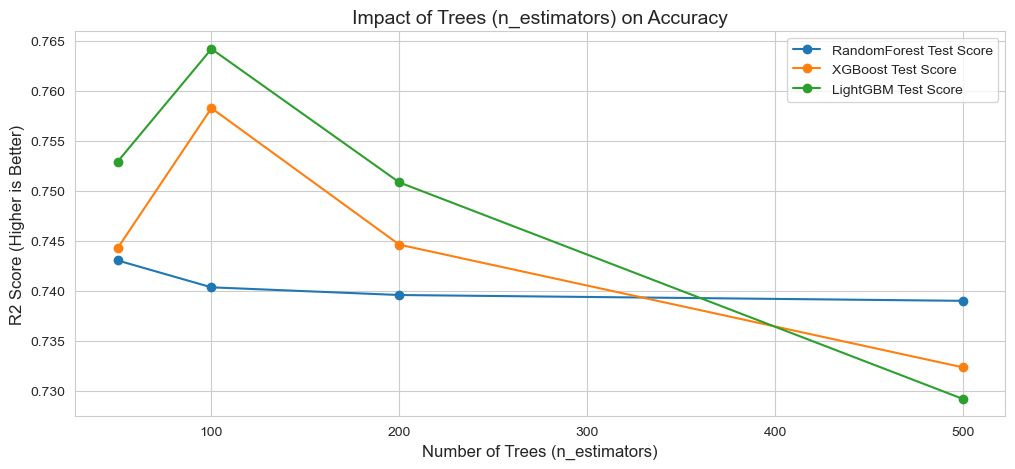

In [14]:
# ------------------------------------------------------------------------------
# 🧪 EXPERIMENT 3: MODEL COMPLEXITY (Finding the "Sweet Spot")
# ------------------------------------------------------------------------------
# Objective: Test how the "Number of Trees" affects performance.
# Hypothesis: More trees = Better accuracy, but only up to a point (diminishing returns).
# ------------------------------------------------------------------------------

import warnings
import matplotlib.pyplot as plt
from sklearn.exceptions import DataConversionWarning

# 1. AGGRESSIVE WARNING SILENCER
warnings.filterwarnings('ignore') 

# 2. The Variable to Test (Number of Trees)
tree_counts = [50, 100, 200, 500]

print(f"\n🧪 STARTING COMPLEXITY EXPERIMENT (Testing {len(tree_counts)} configurations)")
print("=" * 115)
print(f"{'Trees':<10} | {'Model':<15} | {'Test R2':<10} | {'Train R2':<10} | {'RMSE':<12} | {'Gap':<10}")
print("=" * 115)

global_best_r2 = -float('inf')
best_opt_model = None
best_model_name = None 
best_opt_rmse = 0

# Data for plotting later
results_log = {
    'RandomForest': {'x': [], 'test': [], 'train': []},
    'XGBoost':      {'x': [], 'test': [], 'train': []},
    'LightGBM':     {'x': [], 'test': [], 'train': []}
}

# LOOP 1: Iterate through Tree Counts
for n in tree_counts:
    
    # LOOP 2: Iterate through Models
    for name, model_class in zip(models.keys(), [RandomForestRegressor, XGBRegressor, LGBMRegressor]):
        
        # A. Create the Model Manually with the specific 'n_estimators'
        # We assume standard parameters for the rest to isolate the variable 'n'
        if name == 'RandomForest':
            reg = RandomForestRegressor(n_estimators=n, max_depth=10, random_state=42)
        elif name == 'XGBoost':
            reg = XGBRegressor(n_estimators=n, max_depth=5, learning_rate=0.05, objective='reg:squarederror', random_state=42)
        elif name == 'LightGBM':
            reg = LGBMRegressor(n_estimators=n, learning_rate=0.05, num_leaves=31, random_state=42, verbose=-1)
            
        # B. Setup Pipeline (Using k=10 and f_regression as the reliable standard)
        pipeline = Pipeline([
            ('selector', SelectKBest(score_func=f_regression, k=10).set_output(transform="pandas")), 
            ('regressor', reg)
        ])
        
        # C. Fit & Predict
        pipeline.fit(X_train, y_train)
        
        y_pred_test = pipeline.predict(X_test)
        y_pred_train = pipeline.predict(X_train)
        
        # D. Metrics
        r2_test = r2_score(y_test, y_pred_test)
        r2_train = r2_score(y_train, y_pred_train)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        gap = r2_train - r2_test
        
        # E. Log for Plotting
        results_log[name]['x'].append(n)
        results_log[name]['test'].append(r2_test)
        results_log[name]['train'].append(r2_train)
        
        # F. Print Row
        print(f"{n:<10} | {name:<15} | {r2_test:.4f}     | {r2_train:.4f}     | {rmse:.5f}      | {gap:.4f}")
        
        # G. Track Winner
        if r2_test > global_best_r2:
            global_best_r2 = r2_test
            best_opt_rmse = rmse
            best_opt_model = pipeline
            best_model_name = f"{name} (n={n})"

print("=" * 115)
print(f"🏆 COMPLEXITY CHAMPION: {best_model_name} with R2: {global_best_r2:.4f}")

# --- PLOTTING THE "SWEET SPOT" ---
plt.figure(figsize=(12, 5))

# Plot only the winner's class (or all 3 if you prefer) - Let's plot all 3 Test Scores
for name, data in results_log.items():
    plt.plot(data['x'], data['test'], marker='o', label=f'{name} Test Score')

plt.title('Impact of Trees (n_estimators) on Accuracy', fontsize=14)
plt.xlabel('Number of Trees (n_estimators)', fontsize=12)
plt.ylabel('R2 Score (Higher is Better)', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

# Save for the next block
best_opt_r2 = global_best_r2

## 6. Feature Importance Visualization

Extracts and visualizes the top 5 most influential features for each model. This step show exactly which data points the models are prioritizing for their predictions.


Training LightGBM (n=100) for Visualization...
✅ LightGBM (n=100) Top 5 Features:
                 Feature  Importance
       age_group_encoded         894
engagement_level_encoded         519
      device_type_Mobile         346
      content_type_Video         123
       content_type_Text         121


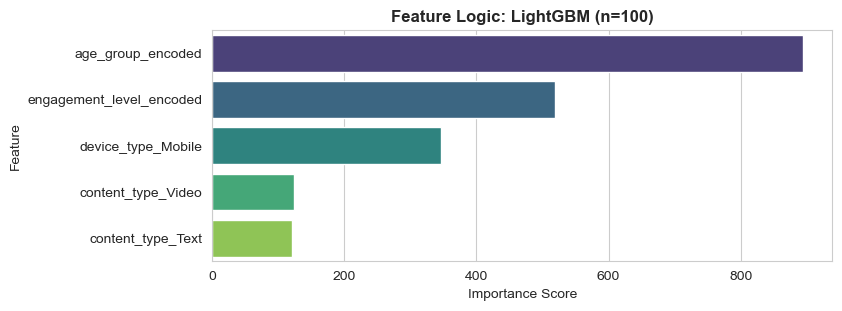

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬


In [15]:
if best_opt_model is not None:
    print(f"\nTraining {best_model_name} for Visualization...")
    
    # Extract parts from pipeline
    selector = best_opt_model.named_steps['selector']
    regressor = best_opt_model.named_steps['regressor']
    
    # Get Feature Names
    selected_mask = selector.get_support()
    selected_names = X_train.columns[selected_mask]
    
    # Extract Feature Importance
    if hasattr(regressor, 'feature_importances_'):
        importances = regressor.feature_importances_
        
        feat_df = pd.DataFrame({
            'Feature': selected_names,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False).head(5)
        
        print(f"✅ {best_model_name} Top 5 Features:")
        print(feat_df.to_string(index=False))
        
        # Plot
        plt.figure(figsize=(8, 3))
        color_map = {'RandomForest': 'Blues_r', 'XGBoost': 'Greens_r', 'LightGBM': 'Purples_r'}
        base_color = color_map.get(best_model_name, 'viridis')
        
        sns.barplot(x='Importance', y='Feature', data=feat_df, palette=base_color)
        plt.title(f'Feature Logic: {best_model_name}', fontsize=12, fontweight='bold')
        plt.xlabel('Importance Score')
        plt.show()
        print("▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬")
    else:
        print(f"⚠️ Model {best_model_name} does not support feature importance.")

## 7. Prediction Evaluation

Selects the best performing model and validates its value by comparing it against a "Naive Baseline" (simply guessing the average conversion rate for everyone).

In [16]:
if best_opt_model is not None:
    final_model = best_opt_model
    model_name = best_model_name
    print(f"✅ Evaluating Optimized Model: {model_name}")
else:
    model_name = list(models.keys())[0]
    final_model = Pipeline([
        ('selector', SelectKBest(score_func=f_regression, k=10)),
        ('regressor', models[model_name])
    ])
    final_model.fit(X_train, y_train)
    print(f"⚠️ Evaluating: First Model ({model_name}) - Winner not found")

y_pred = final_model.predict(X_test)

avg_conversion = y_train.mean()
baseline_preds = np.full(len(y_test), avg_conversion)

baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_preds))
model_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
improvement = baseline_rmse - model_rmse

print(f"\n📊 Baseline Comparison:")
print(f"   1. Baseline RMSE (Guessing Average: {avg_conversion:.2%}): {baseline_rmse:.5f}")
print(f"   2. AI Model RMSE (Your Prediction):                  {model_rmse:.5f}")
print(f"   ---------------------------------------------------------")

if improvement > 0:
    print(f"   ✅ SUCCESS: AI beats the baseline by {improvement:.5f} points!")
else:
    print(f"   ❌ FAIL: The AI is worse than just guessing the average.")

✅ Evaluating Optimized Model: LightGBM (n=100)

📊 Baseline Comparison:
   1. Baseline RMSE (Guessing Average: 15.64%): 0.06151
   2. AI Model RMSE (Your Prediction):                  0.02984
   ---------------------------------------------------------
   ✅ SUCCESS: AI beats the baseline by 0.03167 points!


## 8. Save Model

Persists the final, best performing model to a .joblib file. The filename is automatically versioned with the model type, its R2 accuracy score, and a timestamp to ensure reproducibility and easy tracking of experiments.

In [17]:
#show all columns in order
pd.set_option('display.max_columns', None)
print(X.head())

   time_of_day  age_group_encoded  engagement_level_encoded  \
0            3                  0                       5.0   
1            1                  1                       0.0   
2            0                  1                       0.0   
3            0                  4                      15.0   
4            2                  1                      15.0   

   device_type_Mobile  device_type_Tablet  location_Germany  location_India  \
0                   0                   0                 1               0   
1                   0                   1                 0               0   
2                   1                   0                 0               0   
3                   1                   0                 0               0   
4                   0                   0                 1               0   

   location_UK  location_USA  gender_Male  content_type_Text  \
0            0             0            0                  0   
1            0    

In [18]:
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M")

if 'final_model' in locals() and final_model is not None:
    r2_to_save = best_opt_r2 if 'best_opt_r2' in locals() and best_opt_r2 > -float('inf') else 0.0
    
    filename = f"Advertising_Model_{model_name}_Opt_R2-{r2_to_save:.3f}_{timestamp}.joblib"
    
    # Define Directory
    save_dir = "../Model_Training/Trained_Models/Advertising"
    
    # Create Directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        print(f"📂 Created directory: {save_dir}")
        
    # Save
    save_path = os.path.join(save_dir, filename)
    joblib.dump(final_model, save_path)
    print(f"✅ Saved Advertising Model to: {save_path}")
else:
    print("❌ No model found to save.")

✅ Saved Advertising Model to: ../Model_Training/Trained_Models/Advertising\Advertising_Model_LightGBM (n=100)_Opt_R2-0.764_20260118_0252.joblib
